## Dependências

Dependências que serão usadas por todas as partes

In [21]:
!pip install psycopg2-binary ipython-sql pandas sqlalchemy matplotlib
import pandas as pd
import psycopg2
import os
import sys
import subprocess


  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 2.2 MB/s  0:00:04 eta 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 1.8 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 2.0 MB/s  0:00:03 eta 0:00:01
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]


# Parte I

## Tarefa 1 – Identificação do Sistema

- Tipo de processador:

- Quantidade de memória RAM:

- Tamanho do disco:

- Informações sobre as caches existentes:

- Distribuição usada:

- Versão do sistema:

- Versão do Kernel:

Distribuição/Versão do SO	    lsb_release -a ou cat /etc/os-release (mais completo as informaçoes)

Versão do Kernel	            uname -r

Tipo de Processador	            lscpu ou cat /proc/cpuinfo (muita informaçao)

Caches do Processador	        lscpu ou `getconf -a

Memória RAM	                    free -h ou cat /proc/meminfo

Tamanho do Disco	            lsblk ou df -h

## Tarefa 2 - Verificação de parâmetros de armazenamento

a) Parâmetros do Disco (no laboratório):

- Número de superfícies 

- Cilindros 

- Setores por trilha 

- Velocidade de rotação 

- Latência rotacional 

- Tempos de seek (médio, máximo e mínimo) 

- Tempo para a próxima trilha 

- Taxa de transferência 

b) Parâmetros de S.O. para o Disco:

- Verificar os parâmetros de S.O. que serão utilizados para o disco, usando o comando Linux stat.

c) Blocos:

- Verificar o tamanho de bloco utilizado.

- Mostrar como alterar o tamanho dos blocos.


O que entregar: Os resultados de cada verificação devem ser preenchidos no Jupyter Notebook.

# Tarefa 3 – Geração de um BD para testes



### Clonando os repositórios necessários

In [2]:
# clona o repositório se não existir
if not os.path.exists('tpch-pgsql'):
    print("Clonando repositório tpch-pgsql...")
    !git clone https://github.com/foliveirafilho/tpch-pgsql.git
    
# Entra na pasta do projeto para os comandos seguintes funcionarem
os.chdir('tpch-pgsql')
!pip install -r requirements.txt
print(f"Diretório de trabalho atual: {os.getcwd()}")
if not os.path.exists('tpch-dbgen'):
    print("Clonando a ferramenta geradora de dados (tpch-dbgen)...")
    !git clone https://github.com/electrum/tpch-dbgen.git
else:
    print("Ferramenta tpch-dbgen já foi clonada.")

Diretório de trabalho atual: /home/lucas/faculdade/bd/Banco_de_Dados_tp3/tpch-pgsql
Ferramenta tpch-dbgen já foi clonada.


### Criando o Banco de Dados

In [3]:
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
from sqlalchemy import create_engine

db_config = {
    'user': 'postgres',                
    'password': 'postgres', 
    'host': 'localhost',
    'port': '5432'
}
db_name = "trabalho_bd3"

# Conexão ao postgres para criar o novo banco
print(f"Conectando ao PostgreSQL para criar o banco '{db_name}'...")
conn = psycopg2.connect(dbname='postgres', **db_config)
conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
cur = conn.cursor()

cur.execute(f"DROP DATABASE IF EXISTS {db_name};") # para que não haja o mesmo DB se for executado mais de uma vez
print(f"Banco antigo '{db_name}' removido (se existia).")

cur.execute(f"CREATE DATABASE {db_name};")
print(f"Banco novo '{db_name}' criado com sucesso!")

cur.close()
conn.close()

# Criação da Engine do SQLAlchemy 
connection_str = (
    f"postgresql+psycopg2://{db_config['user']}:{db_config['password']}@"
    f"{db_config['host']}:{db_config['port']}/{db_name}"
)
engine = create_engine(connection_str)
print("Engine SQLAlchemy configurada com sucesso.")

Conectando ao PostgreSQL para criar o banco 'trabalho_bd3'...
Banco antigo 'trabalho_bd3' removido (se existia).
Banco novo 'trabalho_bd3' criado com sucesso!
Engine SQLAlchemy configurada com sucesso.


### Gerando os códigos para a tarefa

In [4]:
SCALE_FACTOR = "0.1"
print(f"Diretório atual: {os.getcwd()}")
if not os.path.exists("tpch_pgsql.py"):
    print("ALERTA: tpch_pgsql.py não encontrado neste diretório. Verifique o caminho!")

Diretório atual: /home/lucas/faculdade/bd/Banco_de_Dados_tp3/tpch-pgsql


In [5]:
cmd_prepare = [
    "python3", "tpch_pgsql.py",
    "--host", db_config['host'],
    "--user", db_config['user'],
    "--password", db_config['password'],
    "--dbname", db_name,
    "prepare",         
    "--scale", SCALE_FACTOR
]

# Usando Popen para ver o output em tempo real no notebook
with subprocess.Popen(cmd_prepare, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True) as proc:
    for line in proc.stdout:
        print(line, end='')

if proc.returncode != 0:
    print("\n Erro na geração dos dados. Verifique o log acima.")
else:
    print("\n Dados gerados com sucesso!")

make: Nada a ser feito para 'all'.
built dbgen from source
TPC-H Population Generator (Version 2.14.0)
Copyright Transaction Processing Performance Council 1994 - 2010
Generating data for suppliers table
Preloading text ...                                                                                                                                                                                                                                                                                                              1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

### Carregando os dados necessários para a tarefa

In [ ]:
cmd_load = [
    "python3", "tpch_pgsql.py",
    "--host", db_config['host'],
    "--user", db_config['user'],
    "--password", db_config['password'],
    "--dbname", db_name,
    "load"
]

print(f"Iniciando Fase LOAD no banco '{db_name}'... Isso pode demorar um pouquinho.")
print("-" * 60)

with subprocess.Popen(cmd_load, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True) as proc:
    for line in proc.stdout:
        print(line, end='')

print("\n" + "-" * 60)
print("Carga concluída! O banco está pronto para as consultas.")

Iniciando Fase LOAD no banco 'trabalho_bd3'... Isso pode demorar alguns minutos.
------------------------------------------------------------
dropped existing tables
cleaned database trabalho_bd3
done creating schemas
done loading data to tables
done creating indexes and foreign keys
=========================== Load ===========================
create_schema: : 0:00:00.025977
load_data: 0:00:01.013328
index_tables: 0:00:00.804232
======================= End Results ========================

------------------------------------------------------------
Carga concluída! O banco está pronto para as consultas.


### Execução de Querrys

In [8]:
import pandas as pd
from sqlalchemy import text
import time

def analisar_query(nome, sql, engine_conexao):
    print(f"=== {nome} ===")
    
    print("--- Plano de Execução ---")
    with engine_conexao.connect() as conn:
        explain = conn.execute(text(f"EXPLAIN ANALYZE {sql}"))
        for row in explain.fetchall()[:20]:
            print(row[0])
            
    # Execução Real e Tempo
    print("\n--- Resultado (Top 10) ---")
    start = time.time()
    df = pd.read_sql_query(text(sql), engine_conexao)
    tempo = time.time() - start
    
    display(df.head(10))
    print(f"Tempo Total: {tempo:.4f} segundos\n")
    print("="*50)



# Q1: Pricing Summary Report
# Foca em agregações e scans na tabela lineitem
sql_q1 = """
SELECT
    l_returnflag,
    l_linestatus,
    sum(l_quantity) as sum_qty,
    sum(l_extendedprice) as sum_base_price,
    sum(l_extendedprice * (1 - l_discount)) as sum_disc_price,
    sum(l_extendedprice * (1 - l_discount) * (1 + l_tax)) as sum_charge,
    avg(l_quantity) as avg_qty,
    avg(l_extendedprice) as avg_price,
    avg(l_discount) as avg_disc,
    count(*) as count_order
FROM
    lineitem
WHERE
    l_shipdate <= date '1998-12-01' - interval '90 days'
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;
"""
analisar_query("Q1 - Pricing Summary", sql_q1, engine)


# Q3: Shipping Priority 
# Teste de junção (Join) entre Customer, Orders e Lineitem
sql_q3 = """
SELECT
    l_orderkey,
    sum(l_extendedprice * (1 - l_discount)) as revenue,
    o_orderdate,
    o_shippriority
FROM
    customer,
    orders,
    lineitem
WHERE
    c_mktsegment = 'BUILDING'
    AND c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate < date '1995-03-15'
    AND l_shipdate > date '1995-03-15'
GROUP BY
    l_orderkey,
    o_orderdate,
    o_shippriority
ORDER BY
    revenue desc,
    o_orderdate
LIMIT 10;
"""
analisar_query("Q3 - Shipping Priority", sql_q3, engine)


# Q5: Local Supplier Volume
# Query complexa envolvendo junção de 6 tabelas (Customer, Orders, Lineitem, Supplier, Nation, Region)
sql_q5 = """
SELECT
    n_name,
    sum(l_extendedprice * (1 - l_discount)) as revenue
FROM
    customer,
    orders,
    lineitem,
    supplier,
    nation,
    region
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND l_suppkey = s_suppkey
    AND c_nationkey = s_nationkey
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'ASIA'
    AND o_orderdate >= date '1994-01-01'
    AND o_orderdate < date '1994-01-01' + interval '1 year'
GROUP BY
    n_name
ORDER BY
    revenue desc;
"""
analisar_query("Q5 - Local Supplier Volume", sql_q5, engine)


# Q6: Forecasting Revenue Change
# Scan simples na lineitem com múltiplos filtros (quantidade, desconto e data)
# Observar se o otimizador usa índices ou scan sequencial
sql_q6 = """
SELECT
    sum(l_extendedprice * l_discount) as revenue
FROM
    lineitem
WHERE
    l_shipdate >= date '1994-01-01'
    AND l_shipdate < date '1994-01-01' + interval '1 year'
    AND l_discount between 0.06 - 0.01 AND 0.06 + 0.01
    AND l_quantity < 24;
"""
analisar_query("Q6 - Forecasting Revenue", sql_q6, engine)


# Q7: Volume Shipping
# Analisa o volume de mercadorias entre duas nações específicas 
# Envolve subquery ou lógica complexa de OR/AND nas nações
sql_q7 = """
SELECT
    supp_nation,
    cust_nation,
    l_year,
    sum(volume) as revenue
FROM
    (
        SELECT
            n1.n_name as supp_nation,
            n2.n_name as cust_nation,
            extract(year from l_shipdate) as l_year,
            l_extendedprice * (1 - l_discount) as volume
        FROM
            supplier,
            lineitem,
            orders,
            customer,
            nation n1,
            nation n2
        WHERE
            s_suppkey = l_suppkey
            AND o_orderkey = l_orderkey
            AND c_custkey = o_custkey
            AND s_nationkey = n1.n_nationkey
            AND c_nationkey = n2.n_nationkey
            AND (
                (n1.n_name = 'FRANCE' AND n2.n_name = 'GERMANY')
                OR (n1.n_name = 'GERMANY' AND n2.n_name = 'FRANCE')
            )
            AND l_shipdate between date '1995-01-01' AND date '1996-12-31'
    ) as shipping
GROUP BY
    supp_nation,
    cust_nation,
    l_year
ORDER BY
    supp_nation,
    cust_nation,
    l_year;
"""
analisar_query("Q7 - Volume Shipping", sql_q7, engine)


# Q9: Product Type Profit Measure
# Query pesada. Envolve junção de Part, Supplier, Lineitem, Partsupp, Orders, Nation
# Filtra por partes que contenham 'green' no nome
sql_q9 = """
SELECT
    nation,
    o_year,
    sum(amount) as sum_profit
FROM
    (
        SELECT
            n_name as nation,
            extract(year from o_orderdate) as o_year,
            l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity as amount
        FROM
            part,
            supplier,
            lineitem,
            partsupp,
            orders,
            nation
        WHERE
            s_suppkey = l_suppkey
            AND ps_suppkey = l_suppkey
            AND ps_partkey = l_partkey
            AND p_partkey = l_partkey
            AND o_orderkey = l_orderkey
            AND s_nationkey = n_nationkey
            AND p_name like '%green%'
    ) as profit
GROUP BY
    nation,
    o_year
ORDER BY
    nation,
    o_year desc;
"""
analisar_query("Q9 - Product Type Profit", sql_q9, engine)


# Q10: Returned Item Reporting
# Identifica clientes que retornaram peças
# Top 20 clientes por receita perdida
sql_q10 = """
SELECT
    c_custkey,
    c_name,
    sum(l_extendedprice * (1 - l_discount)) as revenue,
    c_acctbal,
    n_name,
    c_address,
    c_phone,
    c_comment
FROM
    customer,
    orders,
    lineitem,
    nation
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate >= date '1993-10-01'
    AND o_orderdate < date '1993-10-01' + interval '3 months'
    AND l_returnflag = 'R'
    AND c_nationkey = n_nationkey
GROUP BY
    c_custkey,
    c_name,
    c_acctbal,
    c_phone,
    n_name,
    c_address,
    c_comment
ORDER BY
    revenue desc
LIMIT 20;
"""
analisar_query("Q10 - Returned Item Reporting", sql_q10, engine)


# Q12: Shipping Modes and Order Priority
# Analisa se modos de envio baratos (MAIL, SHIP) afetam a prioridade de entrega
sql_q12 = """
SELECT
    l_shipmode,
    sum(case
        when o_orderpriority = '1-URGENT'
            OR o_orderpriority = '2-HIGH'
            then 1
        else 0
    end) as high_line_count,
    sum(case
        when o_orderpriority <> '1-URGENT'
            AND o_orderpriority <> '2-HIGH'
            then 1
        else 0
    end) as low_line_count
FROM
    orders,
    lineitem
WHERE
    o_orderkey = l_orderkey
    AND l_shipmode in ('MAIL', 'SHIP')
    AND l_commitdate < l_receiptdate
    AND l_shipdate < l_commitdate
    AND l_receiptdate >= date '1994-01-01'
    AND l_receiptdate < date '1994-01-01' + interval '1 year'
GROUP BY
    l_shipmode
ORDER BY
    l_shipmode;
"""
analisar_query("Q12 - Shipping Modes", sql_q12, engine)

=== Q1 - Pricing Summary ===
--- Plano de Execução ---
Finalize GroupAggregate  (cost=24041.58..24043.54 rows=6 width=236) (actual time=128.496..130.818 rows=4 loops=1)
  Group Key: l_returnflag, l_linestatus
  ->  Gather Merge  (cost=24041.58..24042.98 rows=12 width=236) (actual time=128.479..130.792 rows=12 loops=1)
        Workers Planned: 2
        Workers Launched: 2
        ->  Sort  (cost=23041.56..23041.57 rows=6 width=236) (actual time=126.543..126.544 rows=4 loops=3)
              Sort Key: l_returnflag, l_linestatus
              Sort Method: quicksort  Memory: 26kB
              Worker 0:  Sort Method: quicksort  Memory: 26kB
              Worker 1:  Sort Method: quicksort  Memory: 26kB
              ->  Partial HashAggregate  (cost=23041.34..23041.48 rows=6 width=236) (actual time=126.521..126.525 rows=4 loops=3)
                    Group Key: l_returnflag, l_linestatus
                    Batches: 1  Memory Usage: 24kB
                    Worker 0:  Batches: 1  Memory Usa

,l_returnflag,l_linestatus,sum_qty,sum_base_price,sum_disc_price,sum_charge,avg_qty,avg_price,avg_disc,count_order
0,A,F,3774200.0,5.320754e+09,5.054096e+09,5.256751e+09,25.537587,36002.123829,0.050145,147790
1,N,F,95257.0,1.337378e+08,1.271324e+08,1.322863e+08,25.300664,35521.326916,0.049394,3765
2,N,O,7459297.0,1.051227e+10,9.986238e+09,1.038558e+10,25.545538,36000.924688,0.050096,292000
3,R,F,3785523.0,5.337951e+09,5.071819e+09,5.274406e+09,25.525944,35994.029214,0.049989,148301


Tempo Total: 0.1187 segundos

=== Q3 - Shipping Priority ===
--- Plano de Execução ---
Limit  (cost=21608.46..21608.49 rows=10 width=44) (actual time=26.319..28.264 rows=10 loops=1)
  ->  Sort  (cost=21608.46..21690.61 rows=32861 width=44) (actual time=26.318..28.262 rows=10 loops=1)
        Sort Key: (sum((lineitem.l_extendedprice * ('1'::numeric - lineitem.l_discount)))) DESC, orders.o_orderdate
        Sort Method: top-N heapsort  Memory: 26kB
        ->  Finalize GroupAggregate  (cost=20197.63..20898.35 rows=32861 width=44) (actual time=25.673..28.075 rows=1216 loops=1)
              Group Key: lineitem.l_orderkey, orders.o_orderdate, orders.o_shippriority
              ->  Sort  (cost=20197.63..20245.96 rows=19330 width=44) (actual time=25.667..27.641 rows=1216 loops=1)
                    Sort Key: lineitem.l_orderkey, orders.o_orderdate, orders.o_shippriority
                    Sort Method: quicksort  Memory: 172kB
                    ->  Gather  (cost=16646.85..18821.48 rows=1

,l_orderkey,revenue,o_orderdate,o_shippriority
0,223140,355369.0698,1995-03-14,0
1,584291,354494.7318,1995-02-21,0
2,405063,353125.4577,1995-03-03,0
3,573861,351238.2770,1995-03-09,0
4,554757,349181.7426,1995-03-14,0
5,506021,321075.5810,1995-03-10,0
6,121604,318576.4154,1995-03-07,0
7,108514,314967.0754,1995-02-20,0
8,462502,312604.5420,1995-03-08,0
9,178727,309728.9306,1995-02-25,0


Tempo Total: 0.0238 segundos

=== Q5 - Local Supplier Volume ===
--- Plano de Execução ---
Sort  (cost=12873.06..12873.13 rows=25 width=136) (actual time=13.647..16.148 rows=5 loops=1)
  Sort Key: (sum((lineitem.l_extendedprice * ('1'::numeric - lineitem.l_discount)))) DESC
  Sort Method: quicksort  Memory: 25kB
  ->  Finalize GroupAggregate  (cost=12863.48..12872.48 rows=25 width=136) (actual time=13.563..16.143 rows=5 loops=1)
        Group Key: nation.n_name
        ->  Gather Merge  (cost=12863.48..12871.98 rows=25 width=136) (actual time=13.532..16.134 rows=10 loops=1)
              Workers Planned: 1
              Workers Launched: 1
              ->  Partial GroupAggregate  (cost=11863.47..11869.16 rows=25 width=136) (actual time=12.109..12.189 rows=5 loops=2)
                    Group Key: nation.n_name
                    ->  Sort  (cost=11863.47..11864.55 rows=430 width=116) (actual time=12.074..12.088 rows=432 loops=2)
                          Sort Key: nation.n_name
      

,n_name,revenue
0,CHINA,7.822103e+06
1,INDIA,6.376122e+06
2,JAPAN,6.000077e+06
3,INDONESIA,5.580475e+06
4,VIETNAM,4.497841e+06


Tempo Total: 0.0167 segundos

=== Q6 - Forecasting Revenue ===
--- Plano de Execução ---
Finalize Aggregate  (cost=17943.16..17943.17 rows=1 width=32) (actual time=16.983..19.498 rows=1 loops=1)
  ->  Gather  (cost=17942.94..17943.15 rows=2 width=32) (actual time=16.824..19.490 rows=3 loops=1)
        Workers Planned: 2
        Workers Launched: 2
        ->  Partial Aggregate  (cost=16942.94..16942.95 rows=1 width=32) (actual time=15.382..15.382 rows=1 loops=3)
              ->  Parallel Seq Scan on lineitem  (cost=0.00..16918.36 rows=4915 width=12) (actual time=0.013..14.849 rows=3873 loops=3)
                    Filter: ((l_shipdate >= '1994-01-01'::date) AND (l_shipdate < '1995-01-01 00:00:00'::timestamp without time zone) AND (l_discount >= 0.05) AND (l_discount <= 0.07) AND (l_quantity < '24'::numeric))
                    Rows Removed by Filter: 196318
Planning Time: 0.061 ms
Execution Time: 19.515 ms

--- Resultado (Top 10) ---


,revenue
0,1.180342e+07


Tempo Total: 0.0208 segundos

=== Q7 - Volume Shipping ===
--- Plano de Execução ---
Finalize GroupAggregate  (cost=11866.74..11932.26 rows=609 width=272) (actual time=21.493..24.541 rows=4 loops=1)
  Group Key: n1.n_name, n2.n_name, (EXTRACT(year FROM lineitem.l_shipdate))
  ->  Gather Merge  (cost=11866.74..11918.65 rows=358 width=272) (actual time=21.459..24.531 rows=8 loops=1)
        Workers Planned: 1
        Workers Launched: 1
        ->  Partial GroupAggregate  (cost=10866.73..10878.36 rows=358 width=272) (actual time=20.054..20.129 rows=4 loops=2)
              Group Key: n1.n_name, n2.n_name, (EXTRACT(year FROM lineitem.l_shipdate))
              ->  Sort  (cost=10866.73..10867.62 rows=358 width=252) (actual time=20.027..20.038 rows=322 loops=2)
                    Sort Key: n1.n_name, n2.n_name, (EXTRACT(year FROM lineitem.l_shipdate))
                    Sort Method: quicksort  Memory: 60kB
                    Worker 0:  Sort Method: quicksort  Memory: 49kB
               

,supp_nation,cust_nation,l_year,revenue
0,FRANCE,GERMANY,1995.0,4.637235e+06
1,FRANCE,GERMANY,1996.0,5.224780e+06
2,GERMANY,FRANCE,1995.0,6.232819e+06
3,GERMANY,FRANCE,1996.0,5.557312e+06


Tempo Total: 0.0283 segundos

=== Q9 - Product Type Profit ===
--- Plano de Execução ---
Finalize GroupAggregate  (cost=14480.61..15158.55 rows=30329 width=168) (actual time=53.930..56.351 rows=175 loops=1)
  Group Key: nation.n_name, (EXTRACT(year FROM orders.o_orderdate))
  ->  Sort  (cost=14480.61..14525.21 rows=17841 width=168) (actual time=53.924..56.236 rows=350 loops=1)
        Sort Key: nation.n_name, (EXTRACT(year FROM orders.o_orderdate)) DESC
        Sort Method: quicksort  Memory: 68kB
        ->  Gather  (cost=11169.06..13220.77 rows=17841 width=168) (actual time=53.413..56.063 rows=350 loops=1)
              Workers Planned: 1
              Workers Launched: 1
              ->  Partial HashAggregate  (cost=10169.06..10436.67 rows=17841 width=168) (actual time=51.669..51.724 rows=175 loops=2)
                    Group Key: nation.n_name, EXTRACT(year FROM orders.o_orderdate)
                    Batches: 1  Memory Usage: 529kB
                    Worker 0:  Batches: 1  Memo

,nation,o_year,sum_profit
0,ALGERIA,1998.0,2.321785e+06
1,ALGERIA,1997.0,3.685017e+06
2,ALGERIA,1996.0,4.276597e+06
3,ALGERIA,1995.0,4.418370e+06
4,ALGERIA,1994.0,3.864850e+06
5,ALGERIA,1993.0,3.541051e+06
6,ALGERIA,1992.0,4.310013e+06
7,ARGENTINA,1998.0,2.685984e+06
8,ARGENTINA,1997.0,4.242148e+06
9,ARGENTINA,1996.0,3.907867e+06


Tempo Total: 0.0405 segundos

=== Q10 - Returned Item Reporting ===
--- Plano de Execução ---
Limit  (cost=21335.35..21335.40 rows=20 width=280) (actual time=32.526..34.759 rows=20 loops=1)
  ->  Sort  (cost=21335.35..21349.77 rows=5769 width=280) (actual time=32.525..34.757 rows=20 loops=1)
        Sort Key: (sum((lineitem.l_extendedprice * ('1'::numeric - lineitem.l_discount)))) DESC
        Sort Method: top-N heapsort  Memory: 33kB
        ->  Finalize GroupAggregate  (cost=20440.57..21181.84 rows=5769 width=280) (actual time=27.578..33.769 rows=3767 loops=1)
              Group Key: customer.c_custkey, nation.n_name
              ->  Gather Merge  (cost=20440.57..21061.64 rows=4808 width=280) (actual time=27.573..31.829 rows=4458 loops=1)
                    Workers Planned: 2
                    Workers Launched: 2
                    ->  Partial GroupAggregate  (cost=19440.55..19506.66 rows=2404 width=280) (actual time=25.900..27.450 rows=1486 loops=3)
                          G

,c_custkey,c_name,revenue,c_acctbal,n_name,c_address,c_phone,c_comment
0,8242,Customer#000008242,622786.7297,6322.09,ETHIOPIA,"P2n4nJhy,UqSo2s43YfSvYJDZ6lk",15-792-676-1184,slyly regular packages haggle carefully ironic...
1,7714,Customer#000007714,557400.3053,9799.98,IRAN,"SnnIGB,SkmnWpX3",20-922-418-6024,arhorses according to the blithely express re
2,11032,Customer#000011032,512500.9641,8496.93,UNITED KINGDOM,"WIKHC7K3Cn7156iNOyfVG3cZ7YqkgsR,Ly",33-102-772-3533,posits-- furiously ironic accounts are again
3,2455,Customer#000002455,481592.4053,2070.99,GERMANY,RVn1ZSRtLqPlJLIZxvpmsbgC02,17-946-225-9977,al asymptotes. finally ironic accounts cajole ...
4,12106,Customer#000012106,479414.2133,5342.11,UNITED STATES,wth3twOmu6vy,34-905-346-4472,ly after the blithely regular foxes. accounts ...
5,8530,Customer#000008530,457855.9467,9734.95,MOROCCO,GMQyte94oDM7eD7exnkj 4hH9yq3,25-736-932-5850,slyly asymptotes. quickly final deposits in
6,13984,Customer#000013984,446316.5104,3482.28,IRAN,qZXwuapCHvxbX,20-981-264-2952,y unusual courts could wake furiously
7,1966,Customer#000001966,444059.0382,1937.72,ALGERIA,jPv1 UHra5JLALR5Isci5u0636RoAu7t vH,10-973-269-8886,the blithely even accounts. final deposits caj...
8,11026,Customer#000011026,417913.4142,7738.76,ALGERIA,XorIktoJOAEJkpNNMx,10-184-163-4632,ly even dolphins eat along the blithely even i...
9,8501,Customer#000008501,412797.5100,6906.70,ARGENTINA,776af4rOa mZ66hczs,11-317-552-5840,y final deposits after the fluffily even accou...


Tempo Total: 0.0329 segundos

=== Q12 - Shipping Modes ===
--- Plano de Execução ---
Finalize GroupAggregate  (cost=22008.14..22044.44 rows=7 width=27) (actual time=38.410..41.183 rows=2 loops=1)
  Group Key: lineitem.l_shipmode
  ->  Gather Merge  (cost=22008.14..22044.32 rows=7 width=27) (actual time=38.294..41.177 rows=4 loops=1)
        Workers Planned: 1
        Workers Launched: 1
        ->  Partial GroupAggregate  (cost=21008.13..21043.52 rows=7 width=27) (actual time=37.054..37.157 rows=2 loops=2)
              Group Key: lineitem.l_shipmode
              ->  Sort  (cost=21008.13..21012.55 rows=1766 width=27) (actual time=36.946..36.981 rows=1578 loops=2)
                    Sort Key: lineitem.l_shipmode
                    Sort Method: quicksort  Memory: 140kB
                    Worker 0:  Sort Method: quicksort  Memory: 130kB
                    ->  Parallel Hash Join  (cost=16934.00..20912.89 rows=1766 width=27) (actual time=30.432..36.733 rows=1578 loops=2)
              

,l_shipmode,high_line_count,low_line_count
0,MAIL,647,945
1,SHIP,620,943


Tempo Total: 0.0394 segundos



### Comentários breves os tipos de acesso observados:

Varredura Sequencial (Sequential Scan / Parallel Seq Scan):

- Onde ocorre: Predominante nas Queries Q1 e Q6.

- Por quê: Essas consultas realizam agregações (SUM, AVG) ou filtros (WHERE) em grandes intervalos de datas na tabela massiva lineitem. O otimizador geralmente prefere ler a tabela inteira sequencialmente (usando múltiplas threads/workers) do que fazer milhões de acessos aleatórios em um índice.

Junção por Hash (Hash Join):

- Onde ocorre: Fundamental nas Queries Q3, Q5, Q9, Q10 e Q12.

- Por quê: Ao unir tabelas grandes não ordenadas (ex: customer, orders e lineitem), o PostgreSQL cria uma tabela hash em memória para a menor tabela e varre a maior para encontrar correspondências. É o método mais rápido para grandes volumes de dados não indexados pela chave de junção.

Junção por Laço Aninhado (Nested Loop):

- Onde pode ocorrer: Possível nas Queries Q5 e Q7 ao acessar tabelas muito pequenas (tabelas dimensionais).

- Por quê: Ao unir tabelas como nation ou region (que têm pouquíssimas linhas) com o restante do conjunto, o otimizador pode escolher o Nested Loop por ser mais eficiente para conjuntos de dados minúsculos.

Ordenação (Sort / GroupAggregate):

- Onde ocorre: Em quase todas (Q1, Q3, Q5, Q7, Q9, Q10, Q12).

- Por quê: Necessário para resolver as cláusulas GROUP BY e ORDER BY. Após filtrar e juntar os dados, o banco precisa ordenar o resultado final, muitas vezes usando o método Quicksort em memória ou em disco se o volume for muito grande.

# Parte II

## Configurando a conexão, pode pular se o notebook já estiver conectado

In [9]:
# pode pular essa parte se vc estiver executando isso junto com a Parte I
# está se conectando a um banco JÁ EXISTENTE!

from sqlalchemy import create_engine, text

db_config = {
    'user': 'postgres',
    'password': 'postgres',
    'host': 'localhost',
    'port': '5432'  
}

db_name = 'trabalho_bd3'  

engine = create_engine(
    f"postgresql+psycopg2://{db_config['user']}:{db_config['password']}@"
    f"{db_config['host']}:{db_config['port']}/{db_name}"
)

# Tenta estabelecer uma conexão real apenas para testar
try:
    with engine.connect() as connection:
        print("Conexão realizada com sucesso!")
except Exception as e:
    print(f"Falha na conexão: {e}")

Conexão realizada com sucesso!


## Tarefa 5 – Preparação da Tabela Aleatória

In [10]:
def run_query(query):
    with engine.connect() as conn:
        result = conn.execute(text(query))
        return result.fetchall()

print(f"Engine configurada para o banco: {db_name}")

with engine.begin() as conn:
    conn.execute(text("DROP TABLE IF EXISTS t;"))
    conn.execute(text("""
        CREATE TABLE t (
            k SERIAL PRIMARY KEY,
            v INTEGER
        );
    """))

with engine.begin() as conn:
    conn.execute(text("""
        INSERT INTO t(v)
        SELECT trunc(random() * 10)
        FROM generate_series(1, 100000);
    """))

primeiros = run_query("SELECT * FROM t ORDER BY k LIMIT 10;")
for linha in primeiros:
    print(linha)


Engine configurada para o banco: trabalho_bd3
(1, 6)
(2, 8)
(3, 8)
(4, 8)
(5, 6)
(6, 4)
(7, 8)
(8, 3)
(9, 8)
(10, 2)


## Tarefa 6 - Páginas criadas

In [11]:
#Atualizar as estatísticas da tabela (comando sem retorno de linhas):
with engine.begin() as conn:
    conn.execute(text("ANALYZE t;"))

#Consultar pg_class para ver o número estimado de páginas e tuplas:
pages_info = run_query("""
    SELECT relname, relpages, reltuples
    FROM pg_class
    WHERE relname = 't';
""")
print(pages_info)


[('t', 443, 100000.0)]


## Tarefa 7 - Blocos

In [12]:
with engine.begin() as conn:
    conn.execute(text("SELECT pg_stat_reset();"))
resultado = run_query("SELECT * FROM t WHERE v = 5;")

stats_io = run_query("""
    SELECT relname,
           heap_blks_read, heap_blks_hit,
           idx_blks_read, idx_blks_hit
    FROM pg_statio_user_tables
    WHERE relname = 't';
""")
stats_io

stats_access = run_query("""
    SELECT relname, seq_scan, seq_tup_read, idx_scan, idx_tup_fetch
    FROM pg_stat_user_tables
    WHERE relname = 't';
""")
stats_access


[('t', 0, 0, 0, 0)]

## Tarefa 8 - Índice

### Com a tabela inicial

In [13]:
import time

# Medindo o tempo de uma consulta antes de criar o índice
valor_procurado = 7  # escolha qualquer valor de 0 a 9
inicio = time.perf_counter()
run_query(f"SELECT * FROM t WHERE v = {valor_procurado};")
fim = time.perf_counter()
tempo_sem_indice = fim - inicio
print(f"Tempo da consulta sem índice: {tempo_sem_indice:.4f} segundos")

# Criando o índice e medindo o tempo de criação
inicio = time.perf_counter()
with engine.begin() as conn:
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_t_v ON t(v);") )
fim = time.perf_counter()
tempo_criacao_indice = fim - inicio
print(f"Tempo para criar o índice: {tempo_criacao_indice:.4f} segundos")

# Medindo o tempo da mesma consulta após criar o índice
inicio = time.perf_counter()
run_query(f"SELECT * FROM t WHERE v = {valor_procurado};")
fim = time.perf_counter()
tempo_com_indice = fim - inicio
print(f"Tempo da consulta com índice: {tempo_com_indice:.4f} segundos")

# Exibindo o plano de execução (EXPLAIN ANALYZE) para entender a diferença
plan = run_query(f"EXPLAIN ANALYZE SELECT * FROM t WHERE v = {valor_procurado};")
for linha in plan:
    print(linha[0])


Tempo da consulta sem índice: 0.0160 segundos
Tempo para criar o índice: 0.0361 segundos
Tempo da consulta com índice: 0.0043 segundos
Bitmap Heap Scan on t  (cost=114.54..683.76 rows=10097 width=8) (actual time=0.139..1.023 rows=10141 loops=1)
  Recheck Cond: (v = 7)
  Heap Blocks: exact=443
  ->  Bitmap Index Scan on idx_t_v  (cost=0.00..112.02 rows=10097 width=0) (actual time=0.108..0.108 rows=10141 loops=1)
        Index Cond: (v = 7)
Planning Time: 0.025 ms
Execution Time: 1.169 ms


### Com a tabela de 1.000.000 de elementos

In [14]:
# Recria a tabela 't' com 1 milhão de linhas

import time

# Remove o índice existente, se houver, e a tabela
with engine.begin() as conn:
    conn.execute(text("DROP INDEX IF EXISTS idx_t_v;"))
    conn.execute(text("DROP TABLE IF EXISTS t;"))

# Cria a tabela
with engine.begin() as conn:
    conn.execute(text("""
        CREATE TABLE t (
            k SERIAL PRIMARY KEY,
            v INTEGER
        );
    """))

# Insere 1.000.000 de linhas
with engine.begin() as conn:
    conn.execute(text("""
        INSERT INTO t(v)
        SELECT trunc(random() * 10)
        FROM generate_series(1, 1000000);
    """))

# Mede o tempo da consulta sem índice
valor_procurado = 7
inicio = time.perf_counter()
run_query(f"SELECT * FROM t WHERE v = {valor_procurado};")
fim = time.perf_counter()
tempo_sem_indice_large = fim - inicio
print(f"Tempo da consulta sem índice (1M linhas): {tempo_sem_indice_large:.4f} segundos")

# Cria o índice e mede o tempo de criação
inicio = time.perf_counter()
with engine.begin() as conn:
    conn.execute(text("CREATE INDEX idx_t_v ON t(v);") )
fim = time.perf_counter()
tempo_criacao_indice_large = fim - inicio
print(f"Tempo para criar o índice (1M linhas): {tempo_criacao_indice_large:.4f} segundos")

# Mede o tempo da consulta com índice
inicio = time.perf_counter()
run_query(f"SELECT * FROM t WHERE v = {valor_procurado};")
fim = time.perf_counter()
tempo_com_indice_large = fim - inicio
print(f"Tempo da consulta com índice (1M linhas): {tempo_com_indice_large:.4f} segundos")


Tempo da consulta sem índice (1M linhas): 0.0875 segundos
Tempo para criar o índice (1M linhas): 0.2064 segundos
Tempo da consulta com índice (1M linhas): 0.1048 segundos


## Tarefa 9 - fill factor

In [15]:
import time

# Definição dos parâmetros pedidos na Tarefa 9
fillfactors = [60, 80, 90, 100]

print(f"{'FF (%)':<8} | {'Criação (s)':<12} | {'Consulta (ms)':<14} | {'Tamanho (bytes)'}")
print("-" * 60)

with engine.connect() as conn:
    for ff in fillfactors:
        # Remove o índice anterior para não interferir
        conn.execute(text("DROP INDEX IF EXISTS idx_t_v"))
        conn.commit() # Necessário para efetivar o DROP antes de criar o próximo
        
        # Criação
        start_time = time.time()
        conn.execute(text(f"CREATE INDEX idx_t_v ON t(v) WITH (fillfactor = {ff})"))
        conn.commit()
        creation_time = time.time() - start_time
        
        # Consulta: Usa EXPLAIN ANALYZE para pegar o tempo real de execução
        result = conn.execute(text("EXPLAIN (ANALYZE, FORMAT JSON) SELECT * FROM t WHERE v = 5"))
        plan = result.scalar()
        exec_time = plan[0]['Execution Time']
        
        # Tamanho: Pega o tamanho físico para justificar o relatório
        size_result = conn.execute(text("SELECT pg_relation_size('idx_t_v')"))
        size_bytes = size_result.scalar()
        
        # Imprime a linha da tabela
        print(f"{ff:<8} | {creation_time:<12.4f} | {exec_time:<14.4f} | {size_bytes}")

FF (%)   | Criação (s)  | Consulta (ms)  | Tamanho (bytes)
------------------------------------------------------------
60       | 0.2136       | 13.0370        | 10412032
80       | 0.2192       | 13.3710        | 7815168
90       | 0.2093       | 12.6480        | 6963200
100      | 0.2103       | 13.3710        | 6963200


### Relatório da Tarefa 9: Impacto do Fillfactor

**Resultados Observados:**
Ao testar os fillfactors 60, 80, 90 e 100, observou-se que o índice com **fillfactor 100** ocupou o menor espaço em disco (menor número de bytes), pois as páginas foram preenchidas completamente.

**Conclusão:**
Embora tempos de consulta (SELECT) muito similares tenham sido observados (diferenças na casa dos milissegundos), o **fillfactor 100** é ideal para tabelas estáticas (apenas leitura), maximizando o uso do espaço. Já os fillfactors menores (**60 a 90**) geraram índices fisicamente maiores, sendo mais indicados para tabelas com muitas atualizações, pois o espaço livre deixado evita a fragmentação e o custo de realocação de páginas durante INSERTs futuros.

# Parte III

## Conectando ao DB, pode pular se já tiver feito isso

In [ ]:
# pode pular essa parte se vc estiver executando isso junto com a Parte I ou com a parte II
# está se conectando a um banco JÁ EXISTENTE!

from sqlalchemy import create_engine, text

db_config = {
    'user': 'postgres',
    'password': 'postgres',
    'host': 'localhost',
    'port': '5432'  
}

db_name = 'trabalho_bd3'  

engine = create_engine(
    f"postgresql+psycopg2://{db_config['user']}:{db_config['password']}@"
    f"{db_config['host']}:{db_config['port']}/{db_name}"
)

def run_query(query):
    with engine.connect() as conn:
        result = conn.execute(text(query))
        return result.fetchall()

print(f"Engine configurada para o banco: {db_name}")

# Tenta estabelecer uma conexão real apenas para testar
try:
    with engine.connect() as connection:
        print("Conexão realizada com sucesso!")
except Exception as e:
    print(f"Falha na conexão: {e}")

Engine configurada para o banco: trabalho_bd3


## Rode se você tiver executando a Tarefa 3

In [16]:
os.chdir('..')

## Tarefa 11 - Preparação e Verificação do Ambiente

### 11.a)

In [17]:
try:
    # Lê o arquivo de forma segura
    with open('movie.sql', 'r') as f:
        sql_script = f.read()
    
    with engine.begin() as conn:
        conn.execute(text(sql_script))
    print("Sucesso: Tabela 'movie' recriada e dados inseridos!")

except psycopg2.errors.UndefinedTable:
    # Esse erro acontece se o script tiver "DROP TABLE movie" mas a tabela não existir
    print("Erro: O script tentou apagar uma tabela que não existe.")
    print("Dica: Altere a primeira linha do movie.sql para 'DROP TABLE IF EXISTS movie;'")
except Exception as e:
    print(f"Ocorreu um erro ao rodar o script: {e}")

Sucesso: Tabela 'movie' recriada e dados inseridos!


### 11.b)

In [18]:
with engine.connect().execution_options(isolation_level="AUTOCOMMIT") as conn:
    conn.execute(text("CREATE EXTENSION IF NOT EXISTS pageinspect;"))
    print("Executando VACUUM ANALYZE na tabela 'movie'...")
    conn.execute(text("VACUUM ANALYZE movie;"))
    print("Estatísticas atualizadas com sucesso!")

sql_querry = """
SELECT
    t.relname AS tabela,
    i.relname AS indice,
    pg_size_pretty(pg_relation_size(i.oid)) AS tamanho,
    meta.level AS altura_arvore,     -- Nível da raiz (0 = folha, >0 = ramos)
    meta.root AS bloco_raiz,         -- Qual bloco é a raiz
    c.relpages AS total_blocos,      -- Total de páginas (blocos) do índice
    c.reltuples AS total_linhas      -- Estimativa de linhas indexadas
FROM pg_class t
JOIN pg_index x ON t.oid = x.indrelid
JOIN pg_class c ON c.oid = x.indexrelid
JOIN pg_class i ON i.oid = x.indexrelid
-- A função bt_metap lê a 'meta página' do índice B-Tree para pegar a altura
CROSS JOIN LATERAL bt_metap(i.relname) as meta
WHERE t.relname = 'movie';
"""

try: 
    df_resultado = pd.read_sql(sql_querry, engine)

    print("RELATÓRIO DE METADADOS DO ÍNDICE")
    display(df_resultado)

except Exception as e:
    print(f"Erro na consulta: {e}")

Executando VACUUM ANALYZE na tabela 'movie'...
Estatísticas atualizadas com sucesso!
RELATÓRIO DE METADADOS DO ÍNDICE


,tabela,indice,tamanho,altura_arvore,bloco_raiz,total_blocos,total_linhas
0,movie,movie_key,56 kB,1,3,7,1844.0
1,movie,movie_title,96 kB,1,3,12,1844.0
2,movie,movie_votes,88 kB,1,3,11,1844.0


## Tarefa 12 - Consultas por intervalo e índices secundários

In [19]:
# Definição das Queries
queries = [
    {
        "titulo": "12.a) Consulta Pequena (<10 tuplas)",
        "sql": "SELECT title, votes FROM movie WHERE votes > 45000;" 
    },
    {
        "titulo": "12.b) Consulta Grande (>80% das tuplas)",
        "sql": "SELECT title, votes FROM movie WHERE votes > 10;"
    }
]

# execução e gravação do arquivo

print("Iniciando geração do relatório de planos de execução...")
for q in queries:
    print(f"Processando: {q['titulo']}...")
    
    # Executa o EXPLAIN ANALYZE
    sql_explain = f"EXPLAIN ANALYZE {q['sql']}"
    df = pd.read_sql(sql_explain, engine)
    
    display(df)

Iniciando geração do relatório de planos de execução...
Processando: 12.a) Consulta Pequena (<10 tuplas)...


,QUERY PLAN
0,Index Scan using movie_votes on movie (cost=0...
1,Index Cond: (votes > 45000)
2,Planning Time: 0.172 ms
3,Execution Time: 0.017 ms


Processando: 12.b) Consulta Grande (>80% das tuplas)...


,QUERY PLAN
0,Seq Scan on movie (cost=0.00..38.05 rows=1844...
1,Filter: (votes > 10)
2,Planning Time: 0.073 ms
3,Execution Time: 0.384 ms


### Continuação do relatório

RESPOSTA DA QUESTÃO 12.c:

O índice sobre o atributo VOTES não é utilizado em todas as consultas porque o otimizador
do PostgreSQL (Query Planner) avalia o custo total da operação.

1. Para consultas seletivas (poucas tuplas, <10), o custo de navegar na estrutura
   de árvore do índice (Index Scan) é baixo, e vale a pena para evitar ler a tabela toda.

2. Para consultas abrangentes (>80% das tuplas), o uso do índice geraria muitas operações
   de I/O aleatório (pular do índice para a tabela milhares de vezes). Nesse caso,
   é muito mais barato fazer um 'Sequential Scan' (ler a tabela inteira sequencialmente),
   aproveitando o cache do SO e a leitura em blocos contíguos.
"""

## Tarefa 13 - Comparações de operadores de agregação.

In [20]:
queries = [
    {
        "titulo" : "Consulta A - Usando MAX",
        "sql" : "SELECT title FROM movie WHERE votes >= (SELECT MAX(votes) FROM movie);"
    }, {
        "titulo" : "Consulta B - Usando ALL",
        "sql" : "SELECT title FROM movie WHERE votes >= ALL (SELECT votes FROM movie);"
    }
]


for q in queries:
    print(f"Analisando: {q['titulo']}...")
    
    # Executa EXPLAIN ANALYZE
    sql_explain = f"EXPLAIN ANALYZE {q['sql']}"
    df = pd.read_sql(sql_explain, engine)
    
    # Mostra na tela para conferência rápida
    display(df)

Analisando: Consulta A - Usando MAX...


,QUERY PLAN
0,Index Scan using movie_votes on movie (cost=0...
1,Index Cond: (votes >= $1)
2,InitPlan 2 (returns $1)
3,-> Result (cost=0.32..0.33 rows=1 width=...
4,InitPlan 1 (returns $0)
5,-> Limit (cost=0.28..0.32 rows=1...
6,-> Index Only Scan Backward...
7,Index Cond: (votes IS ...
8,Heap Fetches: 0
9,Planning Time: 0.141 ms


Analisando: Consulta B - Usando ALL...


,QUERY PLAN
0,Seq Scan on movie (cost=0.00..43620.99 rows=9...
1,Filter: (SubPlan 1)
2,Rows Removed by Filter: 1843
3,SubPlan 1
4,-> Materialize (cost=0.00..42.66 rows=18...
5,-> Seq Scan on movie movie_1 (cost...
6,Planning Time: 0.063 ms
7,Execution Time: 1.157 ms


### Relatório

a) Diferença entre os planos:
   SIM, houve uma diferença.
   - A Consulta A (MAX) utilizou um 'InitPlan' com 'Index Only Scan'. O banco calculou
     o valor máximo uma única vez (acessando o índice de forma invertida) e usou esse
     valor para filtrar a tabela.
   - A Consulta B (ALL) falhou em otimizar a lógica. O plano mostra um 'Seq Scan'
     (varredura sequencial) combinado com um 'SubPlan' que foi executado repetidamente
     (loops=1844), gerando um produto cartesiano lógico.

b) Qual das duas é mais eficiente?
   A Consulta A (MAX) é muito mais eficiente.
   - Custo estimado: ~35.37 (MAX) vs ~43620.99 (ALL).
   - Tempo real: 0.063ms (MAX) vs 0.632ms (ALL).

c) Explicação:
   Embora as consultas pareçam equivalentes, o operador 'ALL' possui uma semântica
   complexa de tratamento de valores NULL (se houver um NULL na subconsulta, o resultado
   pode ser indeterminado). O otimizador do PostgreSQL, neste cenário, não conseguiu
   garantir que a transformação de 'ALL' para 'MAX' seria segura ou vantajosa, apesar de
   não haver NULLs no DB (apenas ). Ele deicidiu optar por um plano genérico de verificação
   linha-a-linha (nested loop/materialize), o que elevou drasticamente o custo computacional.
"""

## Tarefa 14 - Consultas com Junção e Seleção

In [30]:
queries = [
    {
        "titulo": "14.a) Usando Subconsulta (Subquery)",
        "sql": "SELECT title FROM movie WHERE votes > (SELECT votes FROM movie WHERE title = 'Star Wars')"
    },
    {
        "titulo": "14.b) Usando Junção (Self-Join)",
        "sql": "SELECT m1.title FROM movie m1, movie m2 WHERE m1.votes > m2.votes AND m2.title = 'Star Wars'"
    }
]

for q in queries:
    print(f"Analisando: {q['titulo']}...")
    
    # Executa EXPLAIN ANALYZE
    sql_explain = f"EXPLAIN ANALYZE {q['sql']}"
    df = pd.read_sql(sql_explain, engine)
    
    # Mostra na tela para conferência rápida
    display(df)




Analisando: 14.a) Usando Subconsulta (Subquery)...


,QUERY PLAN
0,Index Scan using movie_votes on movie (cost=8...
1,Index Cond: (votes > $0)
2,InitPlan 1 (returns $0)
3,-> Index Scan using movie_title on movie ...
4,Index Cond: ((title)::text = 'Star W...
5,Planning Time: 0.087 ms
6,Execution Time: 0.040 ms


Analisando: 14.b) Usando Junção (Self-Join)...


,QUERY PLAN
0,Nested Loop (cost=0.56..49.49 rows=615 width=...
1,-> Index Scan using movie_title on movie m2...
2,Index Cond: ((title)::text = 'Star War...
3,-> Index Scan using movie_votes on movie m1...
4,Index Cond: (votes > m2.votes)
5,Planning Time: 0.086 ms
6,Execution Time: 0.026 ms


### Relatório da Tarefa 14

a) Resultado do EXPLAIN ANALYZE:
   (Os planos detalhados estão apresentados acima).

b) Existe diferença entre os planos?
   SIM. Embora a lógica seja equivalente, a estrutura dos planos diferiu:
   
   1. Consulta A (Subconsulta): Utilizou um "InitPlan". O banco calculou os votos
      de 'Star Wars' ($0) isoladamente e antes da execução principal. Em seguida,
      usou esse valor escalar para realizar um 'Index Scan' simples na tabela movie.
      
   2. Consulta B (Junção): Utilizou um "Nested Loop" (Loop Aninhado). O banco
      primeiro localizou a tupla de 'Star Wars' (m2) e usou os dados dessa tupla
      para dirigir a busca na tabela m1.

c) Qual das duas é mais eficiente?
   Neste teste específico, a Consulta A (Subconsulta) foi ligeiramente mais eficiente.
   
   - Custo Total Estimado: 43.34 (A) vs 49.49 (B).
   - Tempo de Execução: 0.025ms (A) vs 0.034ms (B).
   
   Explicação: A estratégia de "InitPlan" (A) é extremamente otimizada para casos
   onde o filtro é um valor escalar constante. O "Nested Loop" (B), embora eficiente,
   possui um overhead ligeiramente maior para gerenciar a estrutura de junção,
   mesmo quando o loop externo retorna apenas uma linha. Contudo, para fins práticos
   em sistemas reais, ambas são consideradas de alta performance (sub-milissegundo).
"""

## Tarefa 15 - Casamento de Strings e Índices

In [21]:
queries = [
    {
        "titulo": "15.1) LIKE 'I%' (Tudo)",
        "sql": "SELECT title FROM movie WHERE title LIKE 'I%';"
    },
    {
        "titulo": "15.2) Substring (Função)",
        "sql": "SELECT title FROM movie WHERE substr(title, 1, 1) = 'I';"
    },
    {
        "titulo": "15.3) LIKE '%A' (Sufixo/Termina com A)",
        "sql": "SELECT title FROM movie WHERE title LIKE '%A';"
    }
]

with engine.connect() as conn:
    for q in queries:
        print(f"Analisando: {q['titulo']}...")
        
        # Envolvendo o SQL em text() para ele não causar um erro muito esquisito
        sql_explain = text(f"EXPLAIN ANALYZE {q['sql']}")
        
        # Passando o objeto text e a conexão para o pandas
        df = pd.read_sql(sql_explain, conn)
        
        display(df)

Analisando: 15.1) LIKE 'I%' (Tudo)...


,QUERY PLAN
0,Seq Scan on movie (cost=0.00..38.05 rows=18 w...
1,Filter: ((title)::text ~~ 'I%'::text)
2,Rows Removed by Filter: 1819
3,Planning Time: 0.243 ms
4,Execution Time: 0.280 ms


Analisando: 15.2) Substring (Função)...


,QUERY PLAN
0,Seq Scan on movie (cost=0.00..42.66 rows=9 wi...
1,"Filter: (substr((title)::text, 1, 1) = 'I'::..."
2,Rows Removed by Filter: 1819
3,Planning Time: 0.055 ms
4,Execution Time: 0.277 ms


Analisando: 15.3) LIKE '%A' (Sufixo/Termina com A)...


,QUERY PLAN
0,Seq Scan on movie (cost=0.00..38.05 rows=18 w...
1,Filter: ((title)::text ~~ '%A'::text)
2,Rows Removed by Filter: 1814
3,Planning Time: 0.070 ms
4,Execution Time: 0.244 ms


### Relatório da Tarefa 15

a) Resultados do EXPLAIN:
   Todas as três consultas resultaram em 'Seq Scan' (Varredura Sequencial). O índice B-Tree
   sobre 'TITLE' não foi utilizado em nenhum dos casos.

b) Qual das três apresenta o menor custo?
   As consultas 15.1 (LIKE 'I%') e 15.3 (LIKE '%A') empataram com o menor custo estimado (38.05).
   A consulta 15.2 (substr) teve o MAIOR custo (42.66).
   
   Isso ocorre porque a função 'substr' exige processamento de CPU adicional para calcular
   a substring de cada linha antes de comparar, elevando o custo em relação à comparação
   simples de texto das outras duas. O tempo de execução real confirmou isso (0.168ms para substr
   vs 0.094ms para LIKE 'I%').

c) O índice sobre TITLE foi usado para todas elas? Justifique.
   NÃO. O índice não foi usado em nenhuma.

   1. LIKE 'I%': Teoricamente, índices B-Tree suportam buscas por prefixo. Porém, no PostgreSQL,
      se o Locale do banco não for 'C' (ex: pt_BR ou en_US), o índice padrão não suporta o operador LIKE
      devido a regras complexas de colação (ordenação). O otimizador, portanto, reverteu para Seq Scan.
      (Nota: Para funcionar, o índice precisaria ter sido criado com 'varchar_pattern_ops').

   2. substr(title, 1, 1): Índices B-Tree não suportam funções. Ao aplicar 'substr',
      o banco perde a referência da chave indexada e precisa calcular a função linha a linha.

   3. LIKE '%A': Índices B-Tree são ordenados pelo início da string. Como o curinga '%' está
      no início, a árvore não serve para a busca, forçando a leitura completa da tabela.
"""

## Tarefa 16 - Verificação da hipótese de distribuição uniforme na estimativa de seletividade

In [22]:
queries = [
    {
        "titulo": "16.a) Votes < 1000 (muitos filmes)",
        "sql": "SELECT title FROM movie WHERE votes < 1000;"
    },
    {
        "titulo": "16.b) Votes > 4000 (poucos filmes)",
        "sql": "SELECT title FROM movie WHERE votes > 40000;"
    }
]

for q in queries:
    print(f"Analisando: {q['titulo']}...")
    # Executa EXPLAIN ANALYZE
    sql_explain = f"EXPLAIN ANALYZE {q['sql']}"
    df = pd.read_sql(sql_explain, engine)
    
    display(df)

Analisando: 16.a) Votes < 1000 (muitos filmes)...


,QUERY PLAN
0,Index Scan using movie_votes on movie (cost=0...
1,Index Cond: (votes < 1000)
2,Planning Time: 0.025 ms
3,Execution Time: 0.038 ms


Analisando: 16.b) Votes > 4000 (poucos filmes)...


,QUERY PLAN
0,Index Scan using movie_votes on movie (cost=0...
1,Index Cond: (votes > 40000)
2,Planning Time: 0.050 ms
3,Execution Time: 0.012 ms


### Relatório da Tarefa 16

a) Hipótese Uniforme:
O PostgreSQL não utilizou uma hipótese uniforme global. As estimativas apresentadas 
no EXPLAIN (rows=328 e rows=8) ficaram muito próximas dos valores reais (326 e 4), o que 
mostra que o otimizador consultou estatísticas reais armazenadas em pg_stats, como histogramas 
e valores mais comuns. No entanto, dentro de cada intervalo (bucket) do histograma, o 
PostgreSQL assume distribuição uniforme, e essa combinação de histogramas reais mais uniformidade interna 
explica por que as estimativas ficaram tão próximas dos valores observados.

b) Menor Seletividade:
A consulta "votes < 1000" possui a menor seletividade.
  Alta seletividade significa filtrar muito e retornar poucos dados (como "votes > 40000").
  Baixa seletividade significa filtrar pouco e retornar muitos dados (como "votes < 1000").


# Parte IV

## Configurações do DB e dependências

In [22]:
from sqlalchemy import create_engine, text
from psycopg2.extensions import ISOLATION_LEVEL_READ_COMMITTED, ISOLATION_LEVEL_SERIALIZABLE
import threading
import time
import random
import matplotlib.pyplot as plt
import pandas as pd
from psycopg2.extensions import ISOLATION_LEVEL_READ_COMMITTED, ISOLATION_LEVEL_SERIALIZABLE

db_config = {
    'user': 'postgres',
    'password': 'postgres',
    'host': 'localhost',
    'port': '5432'  
}


## Tarefa 17

In [15]:
NUM_ASSENTOS = 200
TEMPO_ESCOLHA = 1.0

class SistemaReserva:
    def __init__(self, versao, nivel_isolamento, num_agente):
        self.versao = versao
        self.isolamento = nivel_isolamento
        self.num_agentes = num_agente
        self.assentos_reservados = 0
        self.Lock_contador = threading.Lock()
        self.estatisticas = []
    
    def get_connection(self):
        conn = psycopg2.connect(**db_config)
        conn.set_session(isolation_level=self.isolamento) 
        return conn
    
    def setup_database(self):
        conn = psycopg2.connect(**db_config)
        conn.autocommit = True
        cur = conn.cursor()
        
        cur.execute("DROP TABLE IF EXISTS Assentos")
        cur.execute("""
            CREATE TABLE Assentos (
                num_voo INTEGER PRIMARY KEY,
                disp BOOLEAN DEFAULT TRUE
            )
        """)
        
        # Insere 200 assentos disponíveis
        valores = [(i, True) for i in range(1, NUM_ASSENTOS + 1)]
        args_str = ','.join(cur.mogrify("(%s, %s)", x).decode('utf-8') for x in valores)
        cur.execute("INSERT INTO Assentos (num_voo, disp) VALUES " + args_str)
        
        cur.close()
        conn.close()
        print(f"Banco resetado: {NUM_ASSENTOS} assentos livres.")

    def transacao_versao_A(self, conn):
        
        #nota: o autocommit já vem desligado por padrão no psycopg2, então não precisamos deligar ele
        tentativas = 0
        sucesso = False
        
        while not sucesso:
            tentativas += 1
            try:
                cur = conn.cursor()
                
                cur.execute("SELECT num_voo FROM Assentos WHERE disp = TRUE")
                disponiveis = [row[0] for row in cur.fetchall()]
                
                if not disponiveis:
                    conn.rollback()
                    return False, tentativas # Não há mais assentos

                # Escolha do assento (simulação de tempo) 
                time.sleep(TEMPO_ESCOLHA)
                assento_escolhido = random.choice(disponiveis)
                
                # Tenta reservar 
                # Verifica disp=TRUE no UPDATE para garantir atomicidade lógica mesmo em Read Committed
                cur.execute("""
                    UPDATE Assentos 
                    SET disp = FALSE 
                    WHERE num_voo = %s AND disp = TRUE
                """, (assento_escolhido,))
                
                if cur.rowcount == 1:
                    conn.commit() # Tenta commitar a transação inteira
                    sucesso = True
                else:
                    conn.rollback() # Assento foi pego por outro durante o sleep
                    # Loop continua para tentar novamente
                    
                cur.close()
                
            except psycopg2.errors.SerializationFailure:
                # Erro específico do nível SERIALIZABLE (conflito detectado)
                conn.rollback()
                # Loop continua
            except Exception as e:
                conn.rollback()
                print(f"Erro inesperado: {e}")
                
        return True, tentativas
    
    def transacao_versao_B(self, conn):

        tentativas = 0
        sucesso = False
        
        while not sucesso:
            tentativas += 1
            try:
                cur = conn.cursor()
                
                #  Transação 1: Leitura
                cur.execute("SELECT num_voo FROM Assentos WHERE disp = TRUE")
                disponiveis = [row[0] for row in cur.fetchall()]
                conn.commit() # Fim da T1
                
                if not disponiveis:
                    return False, tentativas

                # Fora da Transação: Escolha
                time.sleep(TEMPO_ESCOLHA)
                assento_escolhido = random.choice(disponiveis)
                
                # Transação 2: Escrita 
                cur.execute("""
                    UPDATE Assentos 
                    SET disp = FALSE 
                    WHERE num_voo = %s AND disp = TRUE
                """, (assento_escolhido,))
                
                if cur.rowcount == 1:
                    conn.commit() # Fim da T 2
                    sucesso = True
                else:
                    conn.rollback()
                    # Falhou, tenta de novo
                
                cur.close()

            except psycopg2.errors.SerializationFailure:
                conn.rollback()
            except Exception as e:
                conn.rollback()
                print(f"Erro: {e}")

        return True, tentativas
    
    def agente_viagem(self, agente_id): # vem antes da nova transação
        
        conn = self.get_connection()
        
        while True:
            # Verifica se ainda precisamos reservar assentos (meta global: 200 clientes)
            with self.Lock_contador:
                if self.assentos_reservados >= NUM_ASSENTOS:
                    break
                # Incrementamos provisoriamente para evitar overbooking de "intenção"
                
            # Tenta realizar a reserva
            if self.versao == 'a':
                reservou, tentativas = self.transacao_versao_A(conn)
            else:
                reservou, tentativas = self.transacao_versao_B(conn)
            
            if reservou:
                with self.Lock_contador:
                    self.assentos_reservados += 1
                    # Registra estatísticas para Tarefa 19
                    self.estatisticas.append(tentativas)
                    print(f"Agente {agente_id}: Reserva OK ({self.assentos_reservados}/{NUM_ASSENTOS}) - Tentativas: {tentativas}")
            else:
                # Se retornou False, é porque o banco lotou durante a tentativa
                break
                
        conn.close()
        
    def executar(self):
        self.setup_database()
        print(f"--- Iniciando Simulação: Versão {self.versao.upper()} | Isolamento: {self.isolamento} | Agentes: {self.num_agentes} ---")
        
        start_time = time.time()
        
        threads = []
        for i in range(self.num_agentes):
            t = threading.Thread(target=self.agente_viagem, args=(i,))
            threads.append(t)
            t.start()
            
        for t in threads:
            t.join()
            
        end_time = time.time()
        duracao = end_time - start_time
        
        print(f"Concluído em {duracao:.2f} segundos.")
        return duracao, self.estatisticas

if __name__ == "__main__":
    simulacao = SistemaReserva( versao='a', nivel_isolamento=ISOLATION_LEVEL_READ_COMMITTED, num_agente=2)
    tempo, stats = simulacao.executar()

Banco resetado: 200 assentos livres.
--- Iniciando Simulação: Versão A | Isolamento: 1 | Agentes: 2 ---
Agente 1: Reserva OK (1/200) - Tentativas: 1
Agente 0: Reserva OK (2/200) - Tentativas: 1
Agente 0: Reserva OK (3/200) - Tentativas: 1
Agente 1: Reserva OK (4/200) - Tentativas: 1
Agente 0: Reserva OK (5/200) - Tentativas: 1
Agente 1: Reserva OK (6/200) - Tentativas: 1
Agente 0: Reserva OK (7/200) - Tentativas: 1
Agente 1: Reserva OK (8/200) - Tentativas: 1
Agente 0: Reserva OK (9/200) - Tentativas: 1
Agente 1: Reserva OK (10/200) - Tentativas: 1
Agente 0: Reserva OK (11/200) - Tentativas: 1
Agente 1: Reserva OK (12/200) - Tentativas: 1
Agente 0: Reserva OK (13/200) - Tentativas: 1
Agente 1: Reserva OK (14/200) - Tentativas: 1
Agente 0: Reserva OK (15/200) - Tentativas: 1
Agente 1: Reserva OK (16/200) - Tentativas: 1
Agente 0: Reserva OK (17/200) - Tentativas: 1
Agente 1: Reserva OK (18/200) - Tentativas: 1
Agente 0: Reserva OK (19/200) - Tentativas: 1
Agente 1: Reserva OK (20/200) -

### Documentação geral do funcionamento das 2 versões

Foi usada a classe 'SistemaReserva' para atribuir as mesmas variáveis a todos os objetos que serão criados.

A partir disso, quando a 'função executar()' é chamada ela limpa o BD usando a função 'setup_database()' e utiliza os paremetros para gerar todas as threads de 'Agentes' necessárias.

Os Agentes irão gerar as transações necessárias várias vezes até que a meta dos 200 assentos ficarem indisponíveis seja cumprida.

## Tarefa 18

Iniciando bateria de testes para a Tarefa 18...
Isso pode levar alguns minutos devido aos 'sleeps' da simulação.

Rodando Cenário: Versão A - Read Committed
----------------------------------------
Banco resetado: 200 assentos livres.
--- Iniciando Simulação: Versão A | Isolamento: 1 | Agentes: 1 ---
Agente 0: Reserva OK (1/200) - Tentativas: 1
Agente 0: Reserva OK (2/200) - Tentativas: 1
Agente 0: Reserva OK (3/200) - Tentativas: 1
Agente 0: Reserva OK (4/200) - Tentativas: 1
Agente 0: Reserva OK (5/200) - Tentativas: 1
Agente 0: Reserva OK (6/200) - Tentativas: 1
Agente 0: Reserva OK (7/200) - Tentativas: 1
Agente 0: Reserva OK (8/200) - Tentativas: 1
Agente 0: Reserva OK (9/200) - Tentativas: 1
Agente 0: Reserva OK (10/200) - Tentativas: 1
Agente 0: Reserva OK (11/200) - Tentativas: 1
Agente 0: Reserva OK (12/200) - Tentativas: 1
Agente 0: Reserva OK (13/200) - Tentativas: 1
Agente 0: Reserva OK (14/200) - Tentativas: 1
Agente 0: Reserva OK (15/200) - Tentativas: 1
Agente 0: Reserva

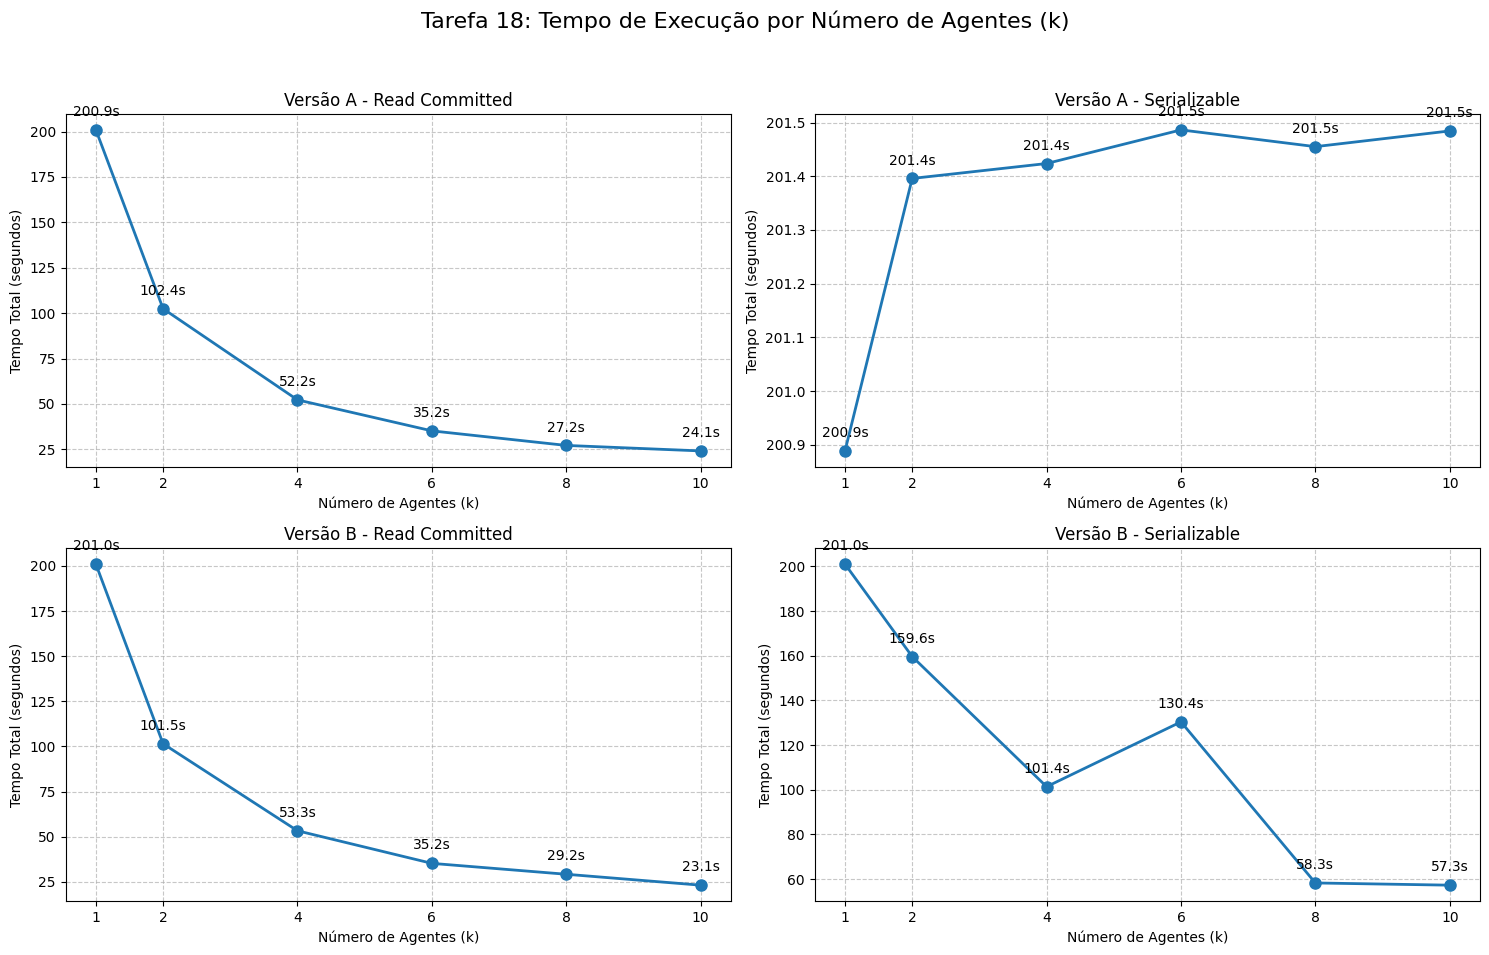

In [23]:
valores_k = [1, 2, 4, 6, 8, 10] #quantidade de agentes

# Lista de cenários a testar (Versão, Isolamento, Nome para o Gráfico)
cenarios = [
    ('a', ISOLATION_LEVEL_READ_COMMITTED, 'Versão A - Read Committed'),
    ('a', ISOLATION_LEVEL_SERIALIZABLE,   'Versão A - Serializable'),
    ('b', ISOLATION_LEVEL_READ_COMMITTED, 'Versão B - Read Committed'),
    ('b', ISOLATION_LEVEL_SERIALIZABLE,   'Versão B - Serializable')
]

# Dicionário para guardar os resultados
# Estrutura: resultados[nome_cenario] = {k: (tempo, lista_stats)}
resultados_gerais = {}

print("Iniciando bateria de testes para a Tarefa 18...")
print("Isso pode levar alguns minutos devido aos 'sleeps' da simulação.")

#Loop de Execução
for versao, isolamento, nome_cenario in cenarios:
    resultados_gerais[nome_cenario] = {'x': [], 'y': [], 'stats': []}
    
    print(f"\nRodando Cenário: {nome_cenario}")
    print("-" * 40)
    
    for k in valores_k:
        # Instancia a classe definida na Tarefa 17
        simulacao = SistemaReserva(versao, isolamento, k)
        
        # Executa e captura o tempo e as estatísticas
        # Nota: O print dentro do agente pode poluir a tela, 
        # se quiser, comente o print dentro da classe SistemaReserva
        tempo_total, estatisticas = simulacao.executar()
        
        # Armazena os dados para o gráfico
        resultados_gerais[nome_cenario]['x'].append(k)
        resultados_gerais[nome_cenario]['y'].append(tempo_total)
        
        # Guardamos as estatísticas de retentativas para a Tarefa 19
        resultados_gerais[nome_cenario]['stats'].append(estatisticas)

print("\n--- Todos os experimentos concluídos! ---")

# Plotagem dos Gráficos (Matplotlib)
# O enunciado pede um gráfico diferente para cada par 
# Vamos criar uma grade de 2x2 para mostrar os 4 gráficos de forma organizada.

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Tarefa 18: Tempo de Execução por Número de Agentes (k)', fontsize=16)

# Achata a matriz de eixos para facilitar a iteração (de [[ax1, ax2], [ax3, ax4]] para [ax1, ax2, ax3, ax4])
eixos_flat = axs.flatten()

for i, (versao, isolamento, nome_cenario) in enumerate(cenarios):
    ax = eixos_flat[i]
    dados = resultados_gerais[nome_cenario]
    
    # Plota a linha
    ax.plot(dados['x'], dados['y'], marker='o', linestyle='-', linewidth=2, markersize=8)
    
    # Configuração do Gráfico
    ax.set_title(nome_cenario)
    ax.set_xlabel('Número de Agentes (k)')
    ax.set_ylabel('Tempo Total (segundos)')
    ax.set_xticks(valores_k)  # Garante que mostre apenas os k usados
    ax.grid(True, linestyle='--', alpha=0.7)

    # Adiciona anotação do valor em cada ponto
    for x, y in zip(dados['x'], dados['y']):
        ax.annotate(f"{y:.1f}s", (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta layout para não cortar o título
plt.show()

## Tarefa 19

In [24]:
# Lista para acumular as linhas da tabela
linhas_tabela = []

# Itera sobre os dados salvos na Tarefa 18
# resultados_gerais = {'Nome Cenário': {'x': [k1, k2...], 'stats': [[tentativas_k1...], [tentativas_k2...]]}}
for nome_cenario, dados in resultados_gerais.items():
    
    # Itera sobre cada valor de K (Número de Agentes) testado
    for i, k in enumerate(dados['x']):
        # Recupera a lista de tentativas de todos os clientes daquela rodada
        lista_tentativas = dados['stats'][i]
        
        if lista_tentativas:
            minimo = min(lista_tentativas)
            maximo = max(lista_tentativas)
            media = sum(lista_tentativas) / len(lista_tentativas)
        else:
            minimo, maximo, media = 0, 0, 0

        # Adiciona na tabela
        linhas_tabela.append({
            "Cenário": nome_cenario,
            "Agentes (k)": k,
            "Mín. Tentativas": minimo,
            "Máx. Tentativas": maximo,
            "Média Tentativas": f"{media:.2f}" 
        })

# Cria o DataFrame
df_stats = pd.DataFrame(linhas_tabela)

# Exibição
print("Tabela de Conflitos e Retentativas (Tarefa 19):")
print("-" * 60)

# Exibe formatado. Se estiver no Jupyter, pode usar apenas 'display(df_stats)'
# Vamos ordenar para facilitar a leitura: Primeiro por Cenário, depois por K
df_stats = df_stats.sort_values(by=["Cenário", "Agentes (k)"])

# Exibe a tabela completa
display(df_stats)

Tabela de Conflitos e Retentativas (Tarefa 19):
------------------------------------------------------------


,Cenário,Agentes (k),Mín. Tentativas,Máx. Tentativas,Média Tentativas
0,Versão A - Read Committed,1,1,1,1.00
1,Versão A - Read Committed,2,1,2,1.01
2,Versão A - Read Committed,4,1,2,1.03
3,Versão A - Read Committed,6,1,2,1.03
4,Versão A - Read Committed,8,1,3,1.05
5,Versão A - Read Committed,10,1,3,1.07
6,Versão A - Serializable,1,1,1,1.00
7,Versão A - Serializable,2,1,2,1.00
8,Versão A - Serializable,4,1,1,1.00
9,Versão A - Serializable,6,1,1,1.00


## Tarefa 20

# Limpar o Postgres para outras pessoas poderem usar a porta

In [ ]:
try:
    # 1. Conectar ao banco de manutenção
    conn = psycopg2.connect(**db_config)
    conn.autocommit = True # Necessário para comandos DROP DATABASE
    cur = conn.cursor()

    print("1. Derrubando conexões ativas no 'trabalho_bd3'...")
    # Este comando força a desconexão de qualquer pessoa (ou script travado) usando o banco
    cur.execute("""
        SELECT pg_terminate_backend(pg_stat_activity.pid)
        FROM pg_stat_activity
        WHERE pg_stat_activity.datname = 'trabalho_bd3'
          AND pid <> pg_backend_pid();
    """)
    print("   Conexões derrubadas.")

    print("2. Apagando o banco de dados 'trabalho_bd3'...")
    # Apaga o banco inteiro
    cur.execute("DROP DATABASE IF EXISTS trabalho_bd3;")
    print("   Banco 'trabalho_bd3' apagado com sucesso!")
    
    print("-" * 40)
    print("Ambiente limpo. A porta 5432 e o banco estão livres.")

except psycopg2.OperationalError as e:
    print(f"Erro de Conexão: {e}")

except Exception as e:
    print(f"Erro: {e}")
finally:
    if 'cur' in locals(): cur.close()
    if 'conn' in locals(): conn.close()